In [36]:
import time
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import pytorch3d.ops
from plyfile import PlyData, PlyElement
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from argparse import ArgumentParser, Namespace
import cv2

from arguments import ModelParams, PipelineParams
from scene import Scene, GaussianModel, FeatureGaussianModel
from gaussian_renderer import render, render_contrastive_feature, render_mask

from utils.sh_utils import SH2RGB

def get_combined_args(parser : ArgumentParser, model_path, target_cfg_file = None):
    cmdlne_string = ['--model_path', model_path]
    cfgfile_string = "Namespace()"
    args_cmdline = parser.parse_args(cmdlne_string)
    
    if target_cfg_file is None:
        if args_cmdline.target == 'seg':
            target_cfg_file = "seg_cfg_args"
        elif args_cmdline.target == 'scene' or args_cmdline.target == 'xyz':
            target_cfg_file = "cfg_args"
        elif args_cmdline.target == 'feature' or args_cmdline.target == 'coarse_seg_everything' or args_cmdline.target == 'contrastive_feature' :
            target_cfg_file = "feature_cfg_args"

    try:
        cfgfilepath = os.path.join(model_path, target_cfg_file)
        print("Looking for config file in", cfgfilepath)
        with open(cfgfilepath) as cfg_file:
            print("Config file found: {}".format(cfgfilepath))
            cfgfile_string = cfg_file.read()
    except TypeError:
        print("Config file found: {}".format(cfgfilepath))
        pass
    args_cfgfile = eval(cfgfile_string)

    merged_dict = vars(args_cfgfile).copy()
    for k,v in vars(args_cmdline).items():
        if v != None:
            merged_dict[k] = v

    return Namespace(**merged_dict)


# Hyper-parameters

In [2]:
import os
FEATURE_DIM = 32
SCALE_AWARE_DIM = 8

DATA_ROOT = './data/nerf_llff_data_for_3dgs/'

# bed bench room sofa lawn
MODEL_PATH = './output/3dovs-sofa'

SPIN_SCENE_NAME = 'orchids'
NVOS_SCENE_NAME = 'trex'
FEATURE_GAUSSIAN_ITERATION = 10000

SCALE_GATE_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(FEATURE_GAUSSIAN_ITERATION)}/scale_gate.pt')

FEATURE_PCD_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(FEATURE_GAUSSIAN_ITERATION)}/contrastive_feature_point_cloud.ply')
SCENE_PCD_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(FEATURE_GAUSSIAN_ITERATION)}/scene_point_cloud.ply')

SAM_ARCH = 'vit_h'
SAM_CKPT_PATH = '../SegmentAnythingin3D/dependencies/sam_ckpt/sam_vit_h_4b8939.pth'

EVAL_TARGET = 'nvos'

# Data and Model Preparation


In [3]:
scale_gate = torch.nn.Sequential(
    torch.nn.Linear(1, 32, bias=True),
    torch.nn.Sigmoid()
)

scale_gate.load_state_dict(torch.load(SCALE_GATE_PATH))
scale_gate = scale_gate.cuda()

scale_aware_dim = SCALE_AWARE_DIM
fixed_scale_gate = torch.tensor([[1 for j in range(32 - scale_aware_dim + i)] + [0 for k in range(scale_aware_dim - i)] for i in range(scale_aware_dim+1)]).cuda()
    
parser = ArgumentParser(description="Testing script parameters")
model = ModelParams(parser, sentinel=True)
pipeline = PipelineParams(parser)
parser.add_argument("--iteration", default=-1, type=int)
parser.add_argument("--skip_train", action="store_true")
parser.add_argument("--skip_test", action="store_true")
parser.add_argument("--quiet", action="store_true")
parser.add_argument("--segment", action="store_true")
parser.add_argument('--target', default='scene', const='scene', nargs='?', choices=['scene', 'seg', 'feature', 'coarse_seg_everything', 'contrastive_feature', 'xyz'])
parser.add_argument('--idx', default=0, type=int)
parser.add_argument('--precomputed_mask', default=None, type=str)

args = get_combined_args(parser, MODEL_PATH)

dataset = model.extract(args)
dataset.need_features = True
dataset.need_masks = True

scene_gaussians = GaussianModel(dataset.sh_degree)

feature_gaussians = FeatureGaussianModel(FEATURE_DIM)
scene = Scene(dataset, scene_gaussians, feature_gaussians, load_iteration=-1, feature_load_iteration=FEATURE_GAUSSIAN_ITERATION, shuffle=False, mode='eval', target='contrastive_feature')


Looking for config file in ./output/3dovs-sofa/cfg_args
Config file found: ./output/3dovs-sofa/cfg_args
Loading trained model at iteration 30000, 10000
Allow Camera Principle Point Shift: False
Reading camera 28/28
Loading Training Cameras
Loading Test Cameras


In [4]:
from sklearn.preprocessing import QuantileTransformer
def get_quantile_func(scales: torch.Tensor, distribution="normal"):
    """
    Use 3D scale statistics to normalize scales -- use quantile transformer.
    """
    scales = scales.flatten()
    scales = scales.detach().cpu().numpy()

    # Calculate quantile transformer
    quantile_transformer = QuantileTransformer(output_distribution=distribution)
    quantile_transformer = quantile_transformer.fit(scales.reshape(-1, 1))

    def quantile_transformer_func(scales):
        # This function acts as a wrapper for QuantileTransformer.
        # QuantileTransformer expects a numpy array, while we have a torch tensor.
        scales_shape = scales.shape

        scales = scales.reshape(-1,1)
        
        return torch.Tensor(
            quantile_transformer.transform(scales.detach().cpu().numpy())
        ).to(scales.device).reshape(scales_shape)

    return quantile_transformer_func

all_scales = []
for cam in scene.getTrainCameras():
    all_scales.append(cam.mask_scales)
all_scales = torch.cat(all_scales)

upper_bound_scale = np.percentile(all_scales.detach().cpu().numpy(), 75)

all_scales = []
for cam in scene.getTrainCameras():
    cam.mask_scales = torch.clamp(cam.mask_scales, 0, upper_bound_scale).detach()
    all_scales.append(cam.mask_scales)
all_scales = torch.cat(all_scales)

# quantile transformer
q_trans = get_quantile_func(all_scales, 'normal')

# Begin Segmenting

In [5]:
from copy import deepcopy
cameras = scene.getTrainCameras()
print("There are",len(cameras),"views in the dataset.")
print(upper_bound_scale)

There are 28 views in the dataset.
1.6044891774654388


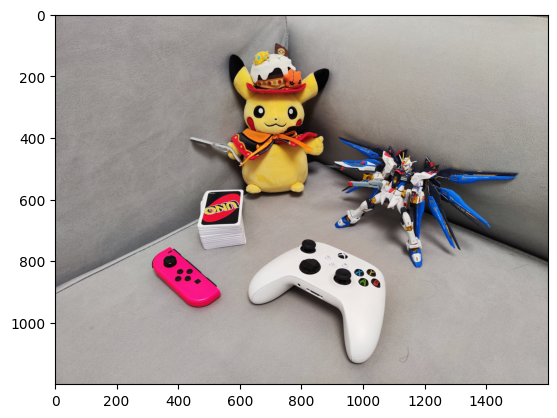

In [6]:
ref_img_camera_id = 0
mask_img_camera_id = 0

view = deepcopy(cameras[ref_img_camera_id])

view.feature_height, view.feature_width = view.image_height, view.image_width
img = view.original_image * 255
img = img.permute([1,2,0]).detach().cpu().numpy().astype(np.uint8)

bg_color = [0 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
rendered_feature = render_contrastive_feature(view, feature_gaussians, pipeline.extract(args), background, norm_point_features=True)['render']
feature_h, feature_w = rendered_feature.shape[-2:]

plt.imshow(img)

# Point Prompt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([5.1993], device='cuda:0')
tensor([2.5697e-03, 9.9992e-01, 5.4542e-12, 1.7667e-14, 1.0415e-10, 7.8166e-05,
        1.0247e-07, 5.6705e-01, 4.8566e-07, 1.3718e-03, 4.8132e-11, 1.4750e-09,
        6.7680e-14, 4.1526e-13, 2.2640e-12, 3.3067e-06, 5.9363e-01, 9.9998e-01,
        7.1422e-13, 9.9597e-12, 4.2534e-03, 4.7647e-01, 2.6488e-11, 1.0000e+00,
        2.6534e-07, 8.4281e-04, 1.0000e+00, 2.0052e-11, 3.7512e-11, 2.7723e-11,
        6.0353e-12, 9.4925e-01], device='cuda:0')


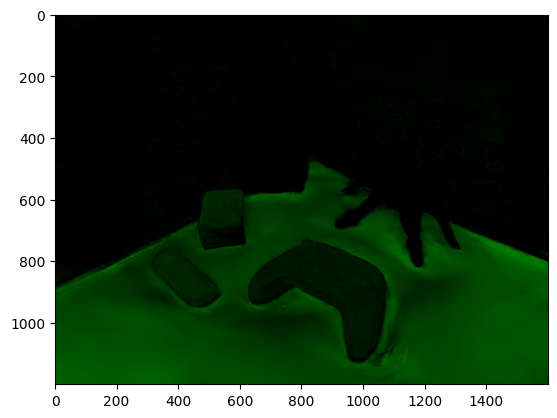

In [7]:
with torch.no_grad():
    scale = upper_bound_scale

    scale = torch.full((1,), scale).cuda()
    scale = q_trans(scale)
    print(scale)

    gates = scale_gate(scale)
    print(gates)

    feature_with_scale = rendered_feature
    feature_with_scale = feature_with_scale * gates.unsqueeze(-1).unsqueeze(-1)
    scale_conditioned_feature = feature_with_scale.permute([1,2,0])

    plt.imshow(scale_conditioned_feature[:,:,:3].detach().cpu().numpy())

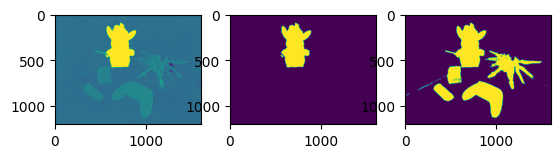

In [9]:
pos_points = torch.tensor([[400, 700]])
neg_points = torch.tensor([[10, 10]])
scribble_h, scribble_w = view.feature_height, view.feature_width

query_index = torch.cat([pos_points, neg_points], dim = 0)

query_index[:, 0] = query_index[:, 0] / scribble_h * view.feature_height
query_index[:, 1] = query_index[:, 1] / scribble_w * view.feature_width
query_index = query_index.long()


normed_features = torch.nn.functional.normalize(scale_conditioned_feature, dim = -1, p = 2)
query_feature = normed_features[query_index[:,0], query_index[:,1], :]


similarity = torch.einsum('NC,HWC->NHW', query_feature, normed_features)
pos_similarity = torch.max(similarity[:len(pos_points),:,:], dim = 0)[0]
neg_similarity = torch.max(similarity[len(pos_points):,:,:], dim = 0)[0]


plt.subplot(1,3,1)
plt.imshow(pos_similarity.detach().cpu().numpy())
plt.subplot(1,3,2)
plt.imshow(pos_similarity.detach().cpu().numpy() > 0.75)
plt.subplot(1,3,3)
plt.imshow(pos_similarity.detach().cpu().numpy() > neg_similarity.detach().cpu().numpy())

# Segmentation in 3D

In [10]:
point_features = feature_gaussians.get_point_features()

scale_conditioned_point_features = point_features * gates.unsqueeze(0)

In [11]:
normed_scale_conditioned_point_features = torch.nn.functional.normalize(scale_conditioned_point_features, dim = -1, p = 2)

similarities = torch.einsum('DC,NC->DN', query_feature, normed_scale_conditioned_point_features)

pos_similarity = torch.max(similarities[:len(pos_points),:], dim = 0)[0]
neg_similarity = torch.max(similarities[len(pos_points):,:], dim = 0)[0]

seg_res = pos_similarity.clone()
seg_res[seg_res < neg_similarity] = 0
seg_res[seg_res < 0.6] = 0
seg_res[seg_res != 0] = 1


In [12]:
try:
    scene_gaussians.roll_back()
except:
    pass
scene_gaussians.segment(pos_similarity > 0.9)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


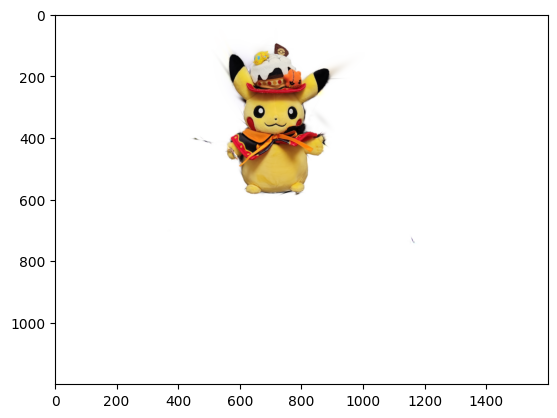

In [13]:
bg_color = [1 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
rendered_segmented_image = render(cameras[mask_img_camera_id], scene_gaussians, pipeline.extract(args), background)['render']
plt.imshow(rendered_segmented_image.permute([1,2,0]).detach().cpu())


In [14]:
scene_gaussians.roll_back()

# Prepare 3D-OVS Data

In [15]:
DATA_ROOT = dataset.source_path
seg_gt_path = os.path.join(DATA_ROOT, 'segmentations')
with open(os.path.join(seg_gt_path, 'classes.txt')) as f:
    seg_gt_list = [l.rstrip() for l in f.readlines()]

annotation_sub_paths = os.listdir(seg_gt_path)
annotation_sub_paths.__delitem__(annotation_sub_paths.index('classes.txt'))

ref_img_camera_ids = [int(idx) for idx in annotation_sub_paths]

gts = {}
for asp in annotation_sub_paths:
    for c in seg_gt_list:
        gt = plt.imread(os.path.join(seg_gt_path, asp, f'{c}.png'))
        gt = gt[:,:,0]
        if int(asp) not in gts.keys():
            gts[int(asp)] = {}
        gts[int(asp)][c] = gt

print(seg_gt_list)

['Pikachu', 'a stack of UNO cards', 'a red Nintendo Switch joy-con controller', 'Gundam', 'Xbox wireless controller', 'grey sofa']


# Language-driven Segmentation

In [16]:
# sample some anchor points in 3D
anchor_point_features = feature_gaussians.get_point_features()[torch.rand(feature_gaussians.get_point_features().shape[0]) > 0.98]
torch.cuda.empty_cache()

In [17]:
from copy import deepcopy

seg_features = []
clip_features = []
scales = []
mask_identifiers = []
camera_id_mask_id = []

# vote_weights = []

bg_color = [0 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

i=0
for view in scene.getTrainCameras():
    torch.cuda.empty_cache()
    clip_features.append(view.original_features)
    tmp_view = deepcopy(view)
    tmp_view.feature_height, tmp_view.feature_width = view.original_image.shape[-2:]

    rendered_feature = render_contrastive_feature(tmp_view, feature_gaussians, pipeline.extract(args), background, norm_point_features=True)['render']
    feature_h, feature_w = rendered_feature.shape[-2:]

    with torch.no_grad():
        # NOTE: 3D-OVS **may need** 8x downsample since its images are in 4K resolution
        # rendered_feature = torch.nn.functional.interpolate(rendered_feature.unsqueeze(0), (feature_h // 8, feature_w // 8), mode = 'bilinear').squeeze()
        # sam_masks = view.original_masks.cuda().unsqueeze(1)
        # sam_masks = torch.nn.functional.interpolate(sam_masks, (feature_h // 8, feature_w // 8), mode = 'bilinear')

        rendered_feature = torch.nn.functional.interpolate(rendered_feature.unsqueeze(0), (feature_h // 4, feature_w // 4), mode = 'bilinear').squeeze()
        sam_masks = view.original_masks.cuda().unsqueeze(1)
        sam_masks = torch.nn.functional.interpolate(sam_masks, (feature_h // 4, feature_w // 4), mode = 'bilinear')


        sam_masks = torch.conv2d(
            sam_masks.float().cpu(),
            torch.full((3, 3), 1.0).view(1, 1, 3, 3).cpu(),
            padding=1,
        )
        sam_masks = sam_masks >= 2
        sam_masks = sam_masks.cuda()

        mask_scales = view.mask_scales.cuda().unsqueeze(-1)
        mask_scales = q_trans(mask_scales)

        scale_gates = scale_gate(mask_scales)

        # N_scale N_anchor C
        scale_conditioned_anchor_point_features = scale_gates.unsqueeze(1) * anchor_point_features.unsqueeze(0)
        scale_conditioned_anchor_point_features = torch.nn.functional.normalize(scale_conditioned_anchor_point_features, dim = -1, p = 2)

        # N_scale C H W
        scale_conditioned_feature = rendered_feature.unsqueeze(0) * scale_gates.unsqueeze(-1).unsqueeze(-1)
        scale_conditioned_feature = torch.nn.functional.normalize(scale_conditioned_feature, dim = 1, p = 2)

        # N_scale C
        mask_features = (sam_masks * scale_conditioned_feature).sum(dim = -1).sum(dim = -1) / (sam_masks.sum(dim = -1).sum(dim = -1) + 1e-9)
        mask_features = torch.nn.functional.normalize(mask_features, dim = -1, p = 2)

        # mask_identifier is the 3D Gaussians retrieved by the 2D mask, if two 3D masks share the same group of indentifier, they are depicting the same 3D target
        mask_identifier = torch.einsum('nmc,nc->nm', scale_conditioned_anchor_point_features, mask_features) > 0.75

        mask_identifiers.append(mask_identifier.cpu())
        seg_features.append(mask_features)
        scales.append(view.mask_scales.cuda().unsqueeze(-1))

        for j in range(len(mask_features)):
            camera_id_mask_id.append((i, j))
        i+=1
torch.cuda.empty_cache()


In [18]:
with torch.no_grad():
    flattened_mask_features = torch.cat(seg_features, dim = 0)
    flattened_clip_features = torch.cat(clip_features, dim = 0)
    flattened_clip_features_without_norm = flattened_clip_features.clone()
    flattened_clip_features = torch.nn.functional.normalize(flattened_clip_features.float(), dim = -1, p = 2)
    flattened_scales = torch.cat(scales, dim = 0)
    flattened_mask_identifiers = torch.cat(mask_identifiers, dim = 0).to(torch.float16)
    flattened_mask_features.shape, flattened_clip_features.shape, flattened_scales.shape, flattened_mask_identifiers.shape, len(camera_id_mask_id)

In [19]:
with torch.no_grad():
    distance_map = 1 - (torch.einsum('mc,nc->mn', flattened_mask_identifiers.cuda(), flattened_mask_identifiers.cuda()) / (flattened_mask_identifiers.sum(dim = -1).unsqueeze(-1).cuda() + flattened_mask_identifiers.sum(dim = -1).unsqueeze(0).cuda() - torch.einsum('mc,nc->mn', flattened_mask_identifiers.cuda(), flattened_mask_identifiers.cuda()) + 1e-6))

In [20]:
from hdbscan import HDBSCAN

clusterer = HDBSCAN(min_cluster_size=len(scene.getTrainCameras()), cluster_selection_epsilon=0.2, metric='precomputed')
cluster_labels = clusterer.fit_predict(distance_map.detach().cpu().numpy().astype(np.float64))
cluster_labels = torch.from_numpy(cluster_labels).to(device = flattened_clip_features.device, dtype = torch.long)


In [21]:
cluster_clip_features = []

for i in cluster_labels.unique():
    if i == -1:
        continue
    cluster_clip_features.append(torch.nn.functional.normalize(flattened_clip_features_without_norm[cluster_labels == i].mean(dim = 0).float(), dim = -1))

cluster_clip_features = torch.stack(cluster_clip_features, dim = 0)

In [22]:
import importlib
import clip_utils
importlib.reload(clip_utils)
from clip_utils import get_scores_with_template, get_scores
from clip_utils.clip_utils import load_clip
importlib.reload(clip_utils.clip_utils)
clip_model = load_clip()
clip_model.eval()
1

Embedding dimension 512


1

In [23]:
def cluster_id_to_scales(cluster_labels, flattened_scales, cluster_id, flattened_scores, positive = True):

    if positive:
        # use the mask with highest semantic response as the representative mask of the 3D cluster, and use its scale as the cluster scale
        am = flattened_scores[cluster_labels == cluster_id].argmax()
    else:
        am = flattened_scores[cluster_labels == cluster_id].argmin()
    return flattened_scales[cluster_labels == cluster_id][am].item()

In [24]:

from typing import Callable
@torch.no_grad()
def get_similarity_map(point_features:torch.Tensor, scale:float, scale_gate:torch.nn.Module, clip_query_feature:torch.Tensor, q_trans:Callable[[torch.Tensor], torch.Tensor]):
    scale = torch.full((1,), scale).cuda()
    scale = q_trans(scale)
    gates = scale_gate(scale)
    scale_conditioned_point_features = point_features * gates.unsqueeze(0)
    normed_scale_conditioned_point_features = torch.nn.functional.normalize(scale_conditioned_point_features, dim = -1, p = 2)
    similarities = torch.einsum('C,NC->N', clip_query_feature, normed_scale_conditioned_point_features)

    return similarities


# Language-driven Semantic Segmentation (3D-OVS)

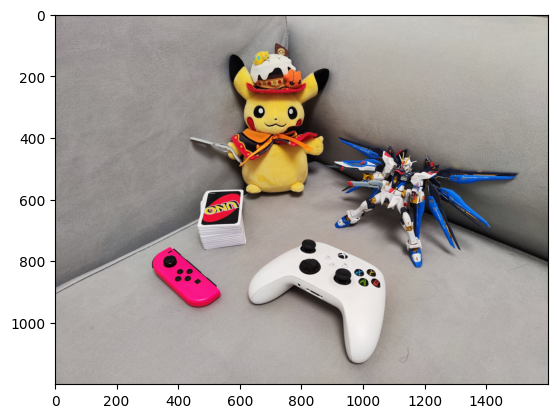

In [25]:
plt.imshow(cameras[0].original_image.permute([1,2,0]).cpu())

In [26]:
default_template = [
    'a bad photo of a {}.',
    'a photo of many {}.',
    'a sculpture of a {}.',
    'a photo of the hard to see {}.',
    'a low resolution photo of the {}.',
    'a rendering of a {}.',
    'graffiti of a {}.',
    'a bad photo of the {}.',
    'a cropped photo of the {}.',
    'a tattoo of a {}.',
    'the embroidered {}.',
    'a photo of a hard to see {}.',
    'a bright photo of a {}.',
    'a photo of a clean {}.',
    'a photo of a dirty {}.',
    'a dark photo of the {}.',
    'a drawing of a {}.',
    'a photo of my {}.',
    'the plastic {}.',
    'a photo of the cool {}.',
    'a close-up photo of a {}.',
    'a black and white photo of the {}.',
    'a painting of the {}.',
    'a painting of a {}.',
    'a pixelated photo of the {}.',
    'a sculpture of the {}.',
    'a bright photo of the {}.',
    'a cropped photo of a {}.',
    'a plastic {}.',
    'a photo of the dirty {}.',
    'a jpeg corrupted photo of a {}.',
    'a blurry photo of the {}.',
    'a photo of the {}.',
    'a good photo of the {}.',
    'a rendering of the {}.',
    'a {} in a video game.',
    'a photo of one {}.',
    'a doodle of a {}.',
    'a close-up photo of the {}.',
    'a photo of a {}.',
    'the origami {}.',
    'the {} in a video game.',
    'a sketch of a {}.',
    'a doodle of the {}.',
    'a origami {}.',
    'a low resolution photo of a {}.',
    'the toy {}.',
    'a rendition of the {}.',
    'a photo of the clean {}.',
    'a photo of a large {}.',
    'a rendition of a {}.',
    'a photo of a nice {}.',
    'a photo of a weird {}.',
    'a blurry photo of a {}.',
    'a cartoon {}.',
    'art of a {}.',
    'a sketch of the {}.',
    'a embroidered {}.',
    'a pixelated photo of a {}.',
    'itap of the {}.',
    'a jpeg corrupted photo of the {}.',
    'a good photo of a {}.',
    'a plushie {}.',
    'a photo of the nice {}.',
    'a photo of the small {}.',
    'a photo of the weird {}.',
    'the cartoon {}.',
    'art of the {}.',
    'a drawing of the {}.',
    'a photo of the large {}.',
    'a black and white photo of a {}.',
    'the plushie {}.',
    'a dark photo of a {}.',
    'itap of a {}.',
    'graffiti of the {}.',
    'a toy {}.',
    'itap of my {}.',
    'a photo of a cool {}.',
    'a photo of a small {}.',
    'a tattoo of the {}.',
]

In [27]:
print(seg_gt_list)
clip_model.set_positives_with_template(seg_gt_list, default_template)

['Pikachu', 'a stack of UNO cards', 'a red Nintendo Switch joy-con controller', 'Gundam', 'Xbox wireless controller', 'grey sofa']


In [28]:
with torch.no_grad():
    # N_mask * N_queries
    seg_scores = clip_model.get_relevancy_with_template(flattened_clip_features.cuda().half())[..., 0]

In [29]:
seg_scores_mean_std = (seg_scores.mean(dim = 0), seg_scores.std(dim = 0))
seg_scores = (seg_scores - seg_scores_mean_std[0]) / seg_scores_mean_std[1]

In [30]:
# Gather the scores of each 3D cluster according to their corresponding 2D masks

# N_cluster, N_queries
cluster_seg_scores = torch.zeros(len(torch.unique(cluster_labels)), seg_scores.shape[1], device=cluster_labels.device)

for cluster_idx in torch.unique(cluster_labels):
    cluster_seg_scores[cluster_idx+1] = seg_scores[cluster_labels == cluster_idx].mean(dim = 0)

print(cluster_seg_scores.shape)

torch.Size([27, 6])


In [31]:
# Show the category of each 3D cluster
for x in range(-1, len(cluster_seg_scores)-1):
    print(x, cluster_seg_scores[x+1], seg_gt_list[cluster_seg_scores[x+1].argmax()])

-1 tensor([-0.2983, -0.0875, -0.2502, -0.1975, -0.2415,  0.0555]) grey sofa
0 tensor([-0.1378, -0.2209, -0.4338, -0.1620,  0.0131,  1.5957]) grey sofa
1 tensor([ 0.2321, -0.3975, -0.3674,  0.0618, -0.0839,  2.2637]) grey sofa
2 tensor([ 0.7891,  0.1250, -0.5601, -0.4236,  0.1183, -0.4683]) Pikachu
3 tensor([ 0.7861,  0.0457, -0.7134, -0.3770, -0.0758, -0.5889]) Pikachu
4 tensor([ 0.3491,  0.2279,  0.2094, -0.5171, -0.2168, -0.2424]) Pikachu
5 tensor([-0.1625, -0.2537, -0.2883, -0.7842, -0.0826, -0.0730]) grey sofa
6 tensor([ 1.8330, -0.3630, -0.2817, -0.0534, -0.5107, -0.5420]) Pikachu
7 tensor([ 0.9268,  0.0640,  0.5342, -0.2169, -0.5347, -0.0884]) Pikachu
8 tensor([ 1.0234, -0.3884, -0.6650, -0.2174,  0.1263,  0.7803]) Pikachu
9 tensor([-0.4714,  0.3669,  0.3640,  0.4978,  0.0643, -0.3735]) Gundam
10 tensor([-0.5771, -0.3374,  2.1953, -0.9331,  0.6973, -0.7656]) a red Nintendo Switch joy-con controller
11 tensor([-0.5273,  0.2073,  0.2269,  0.3599, -0.4348, -0.5679]) Gundam
12 tensor

In [32]:
seg_scores.shape, cluster_seg_scores.shape

(torch.Size([1910, 6]), torch.Size([27, 6]))

In [33]:
# Assign the 3D cluster-level score to each 3D Gaussian for rendering

with torch.no_grad():
    point_scores = None

    no_class_point = None
    for x in range(0, len(cluster_seg_scores)-1):
        cluster_id = x
        scale = cluster_id_to_scales(cluster_labels, flattened_scales, cluster_id, seg_scores[:,cluster_seg_scores[cluster_id+1].argmax()])
        am = seg_scores[:,cluster_seg_scores[cluster_id+1].argmax()][cluster_labels == cluster_id].argmax()
        query_feature = torch.nn.functional.normalize(flattened_mask_features[cluster_labels == cluster_id][am], dim = -1, p = 2)
        similarities = get_similarity_map(feature_gaussians.get_point_features(), scale, scale_gate, query_feature, q_trans)
        if no_class_point is None:
            no_class_point = similarities < 0.5
        else:
            no_class_point = torch.logical_and(no_class_point, similarities < 0.5)

    no_class_point = no_class_point.cuda()

    for x in range(0, len(cluster_seg_scores)-1):
        print(x, cluster_seg_scores[x+1], seg_gt_list[cluster_seg_scores[x+1].argmax()])
        cluster_id = x
        scale = cluster_id_to_scales(cluster_labels, flattened_scales, cluster_id, seg_scores[:,cluster_seg_scores[cluster_id+1].argmax()])
        am = seg_scores[:,cluster_seg_scores[cluster_id+1].argmax()][cluster_labels == cluster_id].argmax()
        query_feature = torch.nn.functional.normalize(flattened_mask_features[cluster_labels == cluster_id][am], dim = -1, p = 2)
        

        similarities = get_similarity_map(feature_gaussians.get_point_features(), scale, scale_gate, query_feature, q_trans)
        
        assign_map = similarities.cuda()
        assign_map[no_class_point] = 0
        assign_map[assign_map > 0.5] = 1
        assign_map[assign_map < 0.5] = 0
        if point_scores is None:
            point_scores = assign_map.unsqueeze(-1) * cluster_seg_scores[x+1].cuda().unsqueeze(0)
        else:
            point_scores += torch.einsum('n,c->nc', assign_map, cluster_seg_scores[x+1].cuda())

0 tensor([-0.1378, -0.2209, -0.4338, -0.1620,  0.0131,  1.5957]) grey sofa
1 tensor([ 0.2321, -0.3975, -0.3674,  0.0618, -0.0839,  2.2637]) grey sofa
2 tensor([ 0.7891,  0.1250, -0.5601, -0.4236,  0.1183, -0.4683]) Pikachu
3 tensor([ 0.7861,  0.0457, -0.7134, -0.3770, -0.0758, -0.5889]) Pikachu
4 tensor([ 0.3491,  0.2279,  0.2094, -0.5171, -0.2168, -0.2424]) Pikachu
5 tensor([-0.1625, -0.2537, -0.2883, -0.7842, -0.0826, -0.0730]) grey sofa
6 tensor([ 1.8330, -0.3630, -0.2817, -0.0534, -0.5107, -0.5420]) Pikachu
7 tensor([ 0.9268,  0.0640,  0.5342, -0.2169, -0.5347, -0.0884]) Pikachu
8 tensor([ 1.0234, -0.3884, -0.6650, -0.2174,  0.1263,  0.7803]) Pikachu
9 tensor([-0.4714,  0.3669,  0.3640,  0.4978,  0.0643, -0.3735]) Gundam
10 tensor([-0.5771, -0.3374,  2.1953, -0.9331,  0.6973, -0.7656]) a red Nintendo Switch joy-con controller
11 tensor([-0.5273,  0.2073,  0.2269,  0.3599, -0.4348, -0.5679]) Gundam
12 tensor([ 0.0981, -0.1531, -0.0716,  1.0400,  0.5864, -0.0453]) Gundam
13 tensor([0

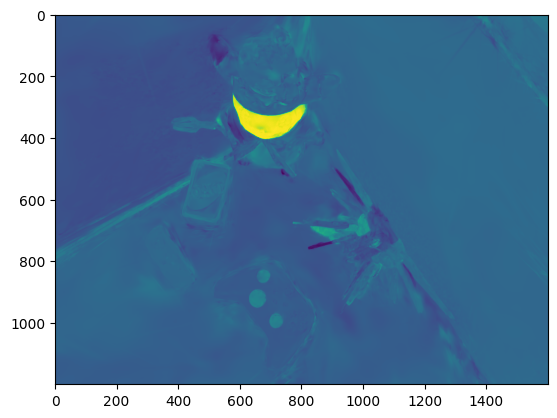

In [37]:
with torch.no_grad():
    idx = 5
    scale = cluster_id_to_scales(cluster_labels, flattened_scales, idx, seg_scores[:,cluster_seg_scores[idx+1].argmax()])
    am = seg_scores[:,cluster_seg_scores[idx+1].argmax()][cluster_labels == idx].argmax()
    query_feature = torch.nn.functional.normalize(flattened_mask_features[cluster_labels == idx][am], dim = -1, p = 2)


    similarities = get_similarity_map(feature_gaussians.get_point_features(), scale, scale_gate, query_feature, q_trans)
    rendered_mask = render_mask(cameras[4], scene_gaussians, pipeline.extract(args), background, precomputed_mask=similarities)['mask']
    plt.imshow(rendered_mask.detach().cpu().squeeze())

In [38]:
# get the per point category score for each 3D Gaussian
point_category_score = point_scores.max(dim = -1)

In [39]:
# Just make sure the scene gaussian is complete
scene_gaussians.roll_back()


In [41]:
with torch.no_grad():
    res = []
    for i in range(len(seg_gt_list)):
        tmp = (point_category_score[1] == i).float().cuda()

        bg_color = [0, 0, 0]
        background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

        rendered_mask = render_mask(cameras[4], scene_gaussians, pipeline.extract(args), background, precomputed_mask=tmp)['mask']
        res.append(rendered_mask.squeeze())
        # print(rendered_mask.squeeze())

    res = torch.stack(res, dim = -1)


In [42]:
gts.keys()

dict_keys([4, 22, 2, 10, 15])

['Pikachu', 'a stack of UNO cards', 'a red Nintendo Switch joy-con controller', 'Gundam', 'Xbox wireless controller', 'grey sofa']


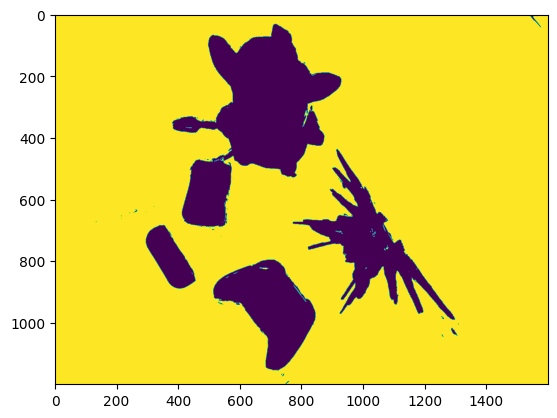

In [43]:
# Show the segmentation results for each category

print(seg_gt_list)
r = res.squeeze().detach().cpu().max(dim = -1)
plt.imshow(r[1] == 5)


In [44]:
with torch.no_grad():
    per_view_res = {}
    for view_id in gts.keys():
        per_view_res[view_id] = {}

        view_gts = gts[view_id]
        for k,v in view_gts.items():
            idx = seg_gt_list.index(k)
            res = []
            for i in range(len(seg_gt_list)):
                tmp = (point_category_score[1] == i).float().cuda()

                bg_color = [0, 0, 0]
                background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

                rendered_mask = render_mask(cameras[view_id], scene_gaussians, pipeline.extract(args), background, precomputed_mask=tmp)['mask']
                res.append(rendered_mask.squeeze())

            res = torch.stack(res, dim = -1)

        for k,v in view_gts.items():
            idx = seg_gt_list.index(k)

            r = res.squeeze().detach().cpu().max(dim = -1)

            seg_map = r[1] == idx

            seg_map = torch.nn.functional.interpolate(seg_map.unsqueeze(0).unsqueeze(0).float(), (v.shape[0], v.shape[1]), mode = 'bilinear').squeeze().squeeze()
            seg_map[seg_map > 0.5] = 1
            seg_map[seg_map != 1] = 0
            seg_map = seg_map.detach().cpu()

            iou = (seg_map * v).sum() / (seg_map.sum() + v.sum() - (seg_map * v).sum())

            per_view_res[view_id][k] = iou


In [45]:
category_iou = {}
mIoU = 0
for category in seg_gt_list:
    for view_id in per_view_res.keys():
        category_iou[category] = category_iou.get(category, 0) + per_view_res[view_id][category]
    category_iou[category] = category_iou[category] / len(per_view_res.keys())
    mIoU += category_iou[category]
mIoU /= len(seg_gt_list)

In [46]:
category_iou, mIoU

({'Pikachu': tensor(0.9444),
  'a stack of UNO cards': tensor(0.9014),
  'a red Nintendo Switch joy-con controller': tensor(0.9585),
  'Gundam': tensor(0.8938),
  'Xbox wireless controller': tensor(0.9447),
  'grey sofa': tensor(0.9855)},
 tensor(0.9381))